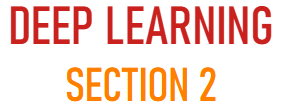

**INSTALLING REQUIRED PACKAGES**

In [ ]:
!pip install -U datasets

In [ ]:
%%capture
!pip install transformers==4.19.2
!pip install rouge_score
!pip install rouge

**DATA PREPROCESSING**

*   Data Processing is done to make the data ready to be studied by the pre-trained model
*   Firstly, the csv file obtained in section 1 is read using pandas module
* The read_csv method of pandas(pd) module is used to read the csv file
* The df.head() returns the 1st five entries of the data



In [ ]:
from datasets import load_metric
import pandas as pd
df = pd.read_csv("/kaggle/input/wikihow-csv/wikiHow.csv",skip_blank_lines=True)
df.head()
import os
os.environ["WANDB_DISABLED"]="true"

In [ ]:
df.shape

The Empty lines and the duplicates must be removed from the data. Duplicates are generated because the url is produced randomly in section one so there’s a chance for the same url to randomly produced. Thankfully these empty and duplicate lines can removed with the help of dropna(inplace=True) and df.drop_duplicates(inplace = True) respectively.
      
The inplace=True argument changes the original dataframe. It is by default False. If False it creates a altered copy of the original dataframe.

In [ ]:
df.dropna(inplace=True)
print(df.shape)

In [ ]:
df.drop_duplicates(inplace=True)
print(df.shape)

**DEALING WITH OUTLIERS**

Outliers happens when the entries are either too low or too high. In order to differentiate the outliers from the rest of the data, we need to plot the data using pyplot of matplotlib module. Before that, we must create another column called length which specifies the length of the paragraph.

The lambda function splits the paragraph by the " " character which is nothing but the spaces between words and the len(x.split(“ “)) returns the number of words in the paragraph.

The paragraph are passed as arguments to the lambda function using map method Thus the fourth column is created.

In [ ]:
df['length'] = df.paragraph.map(lambda x: len(x.split(" ")))

**PLOTTING THE DATA**

We begin by assigning the df.length to a variable named numOfWords to ensure that no changes will be made to the original variable, df. After importing pyplot of Mathplotlib as plt, we define the figure size to be (5,3) (Check the circled area below) which implies the width of the figure must be 5 inches wide and it’s length must be 3 inches.

numOfWords is an one dimensional ndarray which is converted into to a numpy array so that plt.hist can read the data

The bins argument represents the bin edges, that is the starting point and the ending point for the bins along the x-axis. For this histogram figure, the edges are [0,50,100,200,300,500,1000]. Finally plt.show() prints the figure.

In [ ]:
numOfWords = df.length
from matplotlib import pyplot as plt

fig=plt.figure(figsize=(5,3))
plt.hist(numOfWords.to_numpy(), bins=[0,50,100,200,300,500,1000])

plt.title("Word Count Distribution")

plt.show()

**IDENTIFYING AND REMOVING THE OUTLIERS**

From the above figure, we can conclude that most of the paragraphs have words more than thousand and very few paragraphs have words more than 200. Therefore, **these paragraphs with more than 200 words are the outliers**. Hence, we must remove them to have the data ready for further processing. The Below block of code removes the outliers.

In [ ]:
tempDf = df[df.length <= 200]
tempDf.shape

From this, we infer that there was 804 outliers in the dataframe.

**THIS CONCLUDES DATA PREPROCESSING**

**FINE-TUNING WITH LED**

Fine-tuning is the process of training a pre-trained model using the preprocessed dataframe to give meaningful results in our case, relevant titles according to the paragraph

In Our Exercise, we fine-tune the language model called Longformer Encoder Decoder(LED)

**TOKENIZATION**

Tokenization is the process of breaking down the data into smaller segments(tokens) which can be understood by machines. Tokenization enables machines to understand Human Language.

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")

We divide the data in the dataframe into batches to make the training process manageable and efficient. This also prevents overfitting since the process can be interrupted. Overfitting happens when the model memorizes the data instead of learning valuable patterns from the data. Using smaller batches allows the model to diverse into complicated examples and ultimately prevents overfitting. However, the batch size must not be too small. Very Small batches results in the model being inconsistent. Finding the optimal batch size is essential to train a Model. Now we define the function required to process data to model inputs

In [ ]:
max_input_length = 1024
max_output_length = 64
batch_size = 16

def process_data_to_model_inputs(batch):
  #tokenize the inputs and outputs
  inputs = tokenizer(
      batch["paragraph"],
      padding="max_length",
      truncation=True,
      max_length=max_input_length,
  )

  outputs = tokenizer(
      batch["heading"],
      padding="max_length",
      truncation=True,
      max_length=max_output_length,
  )

  batch["input_ids"]=inputs.input_ids
  batch["attention_mask"]=inputs.attention_mask

  #Create 0 global_attention_mask lists
  batch["global_attention_mask"] = len(batch["input_ids"]) * [
      [0 for _ in range(len(batch["input_ids"][0]))]
  ]

  #since above lists are refrences, the following line changes the 0 index of all samples
  batch["global_attention_mask"][0][0] = 1
  batch["labels"] = outputs.input_ids

  #We have to make sure that the PAD token is ignored
  batch["labels"] = [
      [-100 if token == tokenizer.pad_token_id else token for token in labels]
      for labels in batch["labels"]
  ]

  return batch


* Inputs and Outputs are tokenized using the tokenizer created in the previous page
      
* The Inputs are the paragraphs and these paragraphs are divided into batches
      
* padding is done so that every input in the batches have the same length (1024)
      
* Truncation is set to be true in order to match the max input length(Here, 1024)
      
* max length is set to be max input length(1024)
      
* The Same procedure is followed for output tokens except the outputs are the headings

* Attention Mask controls which input sequence the model should pay attention to
      
* The Attention Mask is first set to 0 then the attention mask of every input is set to 1 ensuring equal importance to every input in the batch
      
* Tokens must always be positive(>0). The Tokens which are negative are ignored by the model
      
* Therefore we set the PAD tokens to be -100 so that they are ignored



In [ ]:
import numpy as np
train,validate,test = np.split(tempDf.sample(frac=1, random_state=42),[int(.6*len(df)), int(.7*len(df))])
print(train.shape)
print(validate.shape)
print(test.shape)

* The DataFrame, tempDf is split into train, validate and test cases using split method of numpy
      
* sample method is used to randomize the dataframe
      
* frac argument of sample method represents the percentage of data to be taken from the total data for example if frac=0.5, then only 50% of the entire data will be taken. Here frac is equal to 1 so the entire dataframe will be taken.
      
* random_state argument randomizes the data.


Validate set is reduced to make the training process faster but in practice, it should not be reduced

In [ ]:
validate = validate[:20]

In [ ]:
validate.shape

**CREATING DATASETS**

* We import Dataset from datasets module
      
* The Datasets are created using the from_pandas method of Dataset

In [ ]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(validate)

__TRAINING DATASETS__

* train_dataset obtained in previous page is passed as an argument to process_data_model_inputs defined earlier using the map method
      
* All the unnecessary columns are removed

In [ ]:
train_dataset = train_dataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size = batch_size,
    remove_columns=["title","heading","paragraph","length","__index_level_0__"],
)

The same procedure is followed for val_dataset

In [ ]:
val_dataset = val_dataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size = batch_size,
    remove_columns=["title","heading","paragraph","length","__index_level_0__"],
)

Setting the format of train and val dataset

In [ ]:
train_dataset.set_format(
    type = "torch",
    columns = ["input_ids","attention_mask","global_attention_mask","labels"],
)

val_dataset.set_format(
    type = "torch",
    columns = ["input_ids","attention_mask","global_attention_mask","labels"],
)

Creating the necessary configurations

In [ ]:

from transformers import AutoModelForSeq2SeqLM
from datasets import load_metric
led = AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384", gradient_checkpointing=True, use_cache=False)
led.config.num_beams = 2
led.config.max_length = 64
led.config.min_length = 2
led.config.length_penalty = 2.0
led.config.early_stopping = True 
led.config.no_repeat_ngram_size = 3 
rouge = load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions
    
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True) 
    labels_ids[labels_ids == -100]= tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)
    
    rouge_output = rouge.compute(
        predictions=pred_str, references=label_str, rouge_types=["rouge2"]
    )["rouge2"].mid
    
    return {
        "rouge2_precision": round(rouge_output.precision, 4), 
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments 
import transformers
transformers.logging.set_verbosity_info()

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    output_dir="./",
    logging_steps=5,
    eval_steps=10,
    save_steps=10,
    save_total_limit=2,
    gradient_accumulation_steps=4,
    num_train_epochs=10
)

In [ ]:
trainer = Seq2SeqTrainer(
model=led,
tokenizer=tokenizer,
args=training_args,
compute_metrics=compute_metrics,
train_dataset=train_dataset,
eval_dataset=val_dataset,
)

Training the model

In [ ]:
trainer.train()

Testing The Model

In [ ]:
import pandas as pd
sample_paragraph = "The reason why I loved the top-down culture at Apple is that important decisions are taken faster. Having an expert giving you green light or not keeps the momentum. How many times in a bottom-up culture do we spend weeks and weeks, sometimes even months, trying to get alignment with +10 people, because every single person needs to agree with the point of view? It is exhausting. So again, my experience is that having that one leader to look up to to help guide decisions is time-saving, it helps us focus on the design craft, instead of project management"
df = pd.DataFrame(data,columns=["paragraph"])
df["paragraph"][0]
from datasets import Dataset
df_test = Dataset.from_pandas(df)
df_test

In [ ]:
from datasets import load_metric
import torch

from datasets import load_dataset,load_metric
from transformers import LEDTokenizer,LEDForConditionalGeneration

#load tokenizer
tokenizer = LEDTokenizer.from_pretrained("/kaggle/working/checkpoint-110")
model = LEDForConditionalGeneration.from_pretrained("/kaggle/working/checkpoint-110").to("cuda").half()

def generate_answer(batch):
    inputs_dict = tokenizer(batch["paragraph"], padding="max_length", max_length=512, return_tensors="pt", truncation=True)
    input_ids = input_dict.input_ids.to("cuda")
    attention_mask = inputs_dict.attention_mask.to("cuda")
    global_attention_mask = torch.zeros_like(attention_mask)
    
    predicted_abstract_ids = model.generate(input_ids, attention_mask=attention_mask,global_attention_mask=global_attention_mask)
    batch["generated_heading"] = tokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)
    return batch

result = df_test.map(generate_answer, batched=True, batch_size=2)

In [ ]:
result["generated_heading"]